<a href="https://colab.research.google.com/github/deepskies/proj-clusters-sz-sbi/blob/sim_dev/mass_sampling_functions_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the code to create sample of mass of galaxy clusters based on the halo mass function and redshift distribution. 

original document of single-redshift sampling: https://colab.research.google.com/drive/1pK9xwy4FDU39mkhVPtj0yXC1lBJZll6U
original document of multi-redshift sampling: https://colab.research.google.com/drive/1k9C9HvyX9CwArDmRoK4Ypz_FdeTC7rnt

Packages:
1. colossus, https://bdiemer.bitbucket.io/colossus/lss_mass_function.html#lss.mass_function.massFunction
2. scipy interpolation: https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
3. scipy integration: https://docs.scipy.org/doc/scipy/tutorial/integrate.html
4. emcee for MCMC: https://emcee.readthedocs.io/en/stable/user/sampler/
5. redshift distribution (used skewed gaussian to imitate): https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html#scipy.stats.skewnorm

Hanzhi Tan


In [6]:
# all packages
! pip install colossus

from colossus.cosmology import cosmology
from colossus.lss import mass_function
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import preprocessing
from scipy import interpolate
from scipy import integrate

import math
!pip install emcee
import emcee
import random

import time

import os
from scipy.stats import skewnorm
from pathlib import Path
import pandas as pd
import matplotlib.cm as cm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Single Redshift**

In [7]:
#extract power function
def extract_power(mass_arr):
  """
  Function to extract the power of galaxy cluster mass array, switch from 10^n to n
  
  parameters:
  -----------
  mass_arr: 1d NumPy array of cluster mass in 10^n M⊙ unit
  
  mass_arr_p: 1d numpy array of mass of power = n
  """
  mass_arr_p = np.log10(mass_arr)
  return mass_arr_p

In [8]:
def reverse_extract_power(prim_mass_sample):
    """
    switch from n to 10^n

    Parameters:
    ----------- 
    prim_mass_sample: a priliminary numpy array

    mass_sample: a numpy array of cluter mass after unit transformation
    """
    mass_sample = np.power(10, prim_mass_sample)
    return mass_sample


In [9]:
#the likelihood function
def lnpo(mass, min, max, test_fun):
  """
  likelihood function used by MCMC

  parameters:
  -----------
  mass: a float or a 1d numpy array of cluster mass in 10^n M⊙ unit
  """
  if (mass < min) or (mass > max):
    return -np.inf
  return math.log(test_fun(mass)) #log likelihood is required by emcee

In [10]:
def interpolate_MCMC(mass_array_p, mfunc_n, mass_range, sample_num, redshift):
    """
    interpolate and normalize mfunc_n, use the result as a likelihood function and perform MCMC method to get the sample.
    
    parameters:
    -----------
    mass_arr_p: 1d NumPy array of cluster mass power (for example, 10^14 M⊙ represented as 14 in arr)
    mfunc_n: 1d NumPy array of halo number density * 10^5
    mass_range: a tuple of cluster masses, lower limit, and upper limit for sampling
    sample_num: an integer of the number of samples
    
    sample_chain.flatten(): an 1d numpy array of mass sampling, same unit as mass_arr_p
    """

    min, max = mass_range
    #interpolate
    from scipy import interpolate
    interpolate_mfunc = interpolate.interp1d(mass_array_p, mfunc_n)
    test_arr = np.linspace(min, max, 5000)
    f_test = interpolate_mfunc(test_arr)
    #normalize to likelihood function by divided by integration, looking for better method
    from scipy import integrate
    val, err = integrate.quad(interpolate_mfunc, min, max)
    test_fun = interpolate.interp1d(test_arr, (f_test/val))
    #plt.plot(test_arr, f_test/val, marker = 'o')
    #nval, nerr = integrate.quad(test_fun, min, max), 5000 test points will lead to error < 10^-4

    #create random walkers
    import emcee
    import random
    randomlist = []
    for i in range(20):
        n = random.uniform(min, max)
        randomlist.append(n)
    random_arr = np.array(randomlist)

    ndim, nwalkers = 1, 20
    ###this means that the sample must be larger than 20, otherwise it'll return error###

    #backend setup (discarded)
    # name = "rs_" + str(redshift) + "_sn_" + str(sample_num)
    # file_name = "mcmc_save.h5"
    # backend = emcee.backends.HDFBackend(filename, name = name)
    # backend.reset(nwalkers, ndim)

    #run MCMC
    import time
    process_sample_num = sample_num // (ndim * nwalkers)
    p0 = random_arr.reshape((nwalkers, ndim))
    the_random = random.uniform(1.0, 100.0)
    locals()["sample" + str(the_random)] = emcee.EnsembleSampler(nwalkers, ndim, lnpo, args = [min, max, test_fun])
    t0=time.time()
    pos, prob, state = locals()["sample" + str(the_random)].run_mcmc(p0, 25000) #burn-in sequence
    locals()["sample" + str(the_random)].reset()
    t1=time.time()
    print( ' Done with burn-in: ', t1-t0)
    locals()["sample" + str(the_random)].run_mcmc(pos, process_sample_num)
    t2=time.time()
    print( ' Done with MCMC: ', t2-t1)

    mass_chain = locals()["sample" + str(the_random)].chain
    locals()["sample" + str(the_random)].reset() #prevent storing error
    return test_fun, mass_chain.flatten()


In [11]:
def mass_sampling(mass_range, redshift = 0.0, mdef = '200c', model = 'bocquet16', sample_num = 100000):
    """
    the function to give back a sample of cluster mass distribution based on the halo mass function
      
    Parameters:
    -----------
    mass_range: a tuple of cluster masses, lower limit, and upper limit for sampling
    redshift: a float, 0.0 by default
    sample_num: an integer of the number of samples, 100000 by default
    mdef: The mass definition in which the halo mass M is given
    model: the halo mass function model used by colossus
    
    mass_chain: a NumPy array of length = sample_num.
    test_func: the likelihood function
    """
    from colossus.cosmology import cosmology
    from colossus.lss import mass_function
    import numpy as np
    min, max = mass_range
    mass_arr = np.logspace(min, max, num = 200, base = 10)
    cosmology.setCosmology('WMAP9')
    mfunc = mass_function.massFunction(mass_arr, redshift, mdef = mdef, model = model, q_out = 'dndlnM')
    mass_arr_p = extract_power(mass_arr)
    test_func, prim_mass_sample = interpolate_MCMC(mass_arr_p, mfunc, mass_range, sample_num, redshift)
    return test_func, prim_mass_sample

test single redshift

In [12]:
#code to demonstrate the final result
def plot_pdf(xr, title, func=None, args=None, label='ITS method', 
             ylog=True,
             bins = 50, xlims=[], ylims=[], figsize=3):
    """
    by Andrey Kravtsov
    wrapper convenience function for plotting  histogram of a sequence of floats xr
    and comparing it to a theoretical distribution given by func
    
    Parameters:
    -----------
    xr: 1d numpy array of floats, values in the sequence to plot
    func: Python function object handle
    args: list of arguments to the function
    other parameters are used for plotting
    """
    plt.figure(figsize=(figsize,figsize))
    if ylog: plt.yscale('log') # plot y-values on a logarithmic scale
    if ylims: plt.ylim(ylims) # set axis limits 
    if xlims: plt.xlim(xlims)
    # compute histogram values 
    hist, bins, patches = plt.hist(xr, density=True, bins=bins, label=label)
    binc = 0.5*(bins[1:] + bins[:-1]) # compute bin centers
    plt.plot(binc, func(binc), lw=5, c='orangered', label='target pdf')
    plt.title(title, fontsize=3*figsize)
    plt.ylabel(r'$likelihood$') # label axis 
    plt.xlabel(r'$mass$')
    plt.legend(loc='best', frameon=False, fontsize=3*figsize)
    plt.show()

In [13]:
index = [0, 1]
mass_range = (14.0, 16.0)
mass_chain = []
for i in index:
  test_func, chain = mass_sampling(mass_range, redshift = i, sample_num = 1000)
  mass_chain.append(chain.tolist())


 Done with burn-in:  33.83459973335266
 Done with MCMC:  0.053278207778930664
Deleted outdated persistence file, no further action needed.
 Done with burn-in:  22.519156217575073
 Done with MCMC:  0.048538923263549805


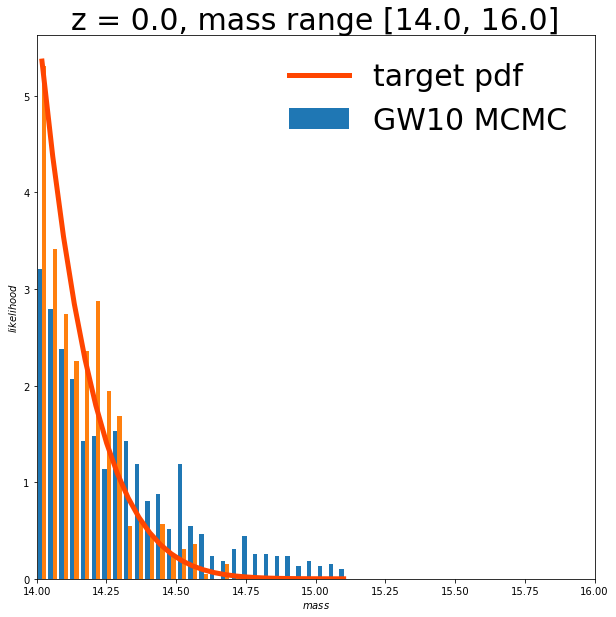

In [14]:
plot_pdf(mass_chain, "z = 0.0, mass range [14.0, 16.0]", func=test_func, xlims=mass_range, ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
 Done with burn-in:  34.05172300338745
 Done with MCMC:  4.534182548522949


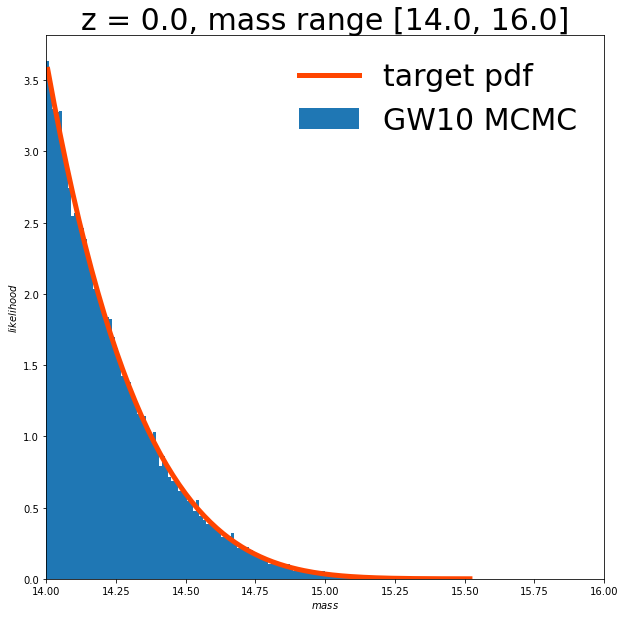

In [15]:
#simplest case
mass_range = [14.0, 16.0]
test_func, mass_chain = mass_sampling(mass_range)
plot_pdf(mass_chain, "z = 0.0, mass range [14.0, 16.0]", func=test_func, xlims=mass_range, ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
 Done with burn-in:  22.65102243423462
 Done with MCMC:  4.500755548477173


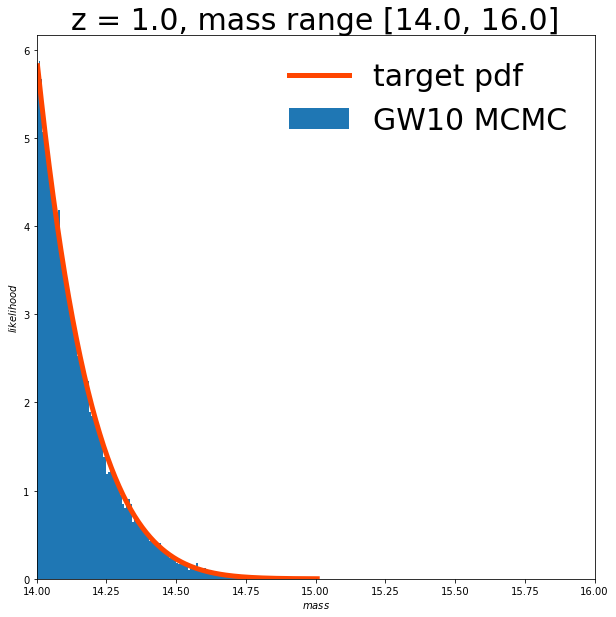

In [16]:
test_func, mass_chain = mass_sampling(mass_range, redshift = 1.0)
plot_pdf(mass_chain, "z = 1.0, mass range [14.0, 16.0]", func=test_func, xlims=mass_range, ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


 Done with burn-in:  22.615280151367188
 Done with MCMC:  5.580808877944946


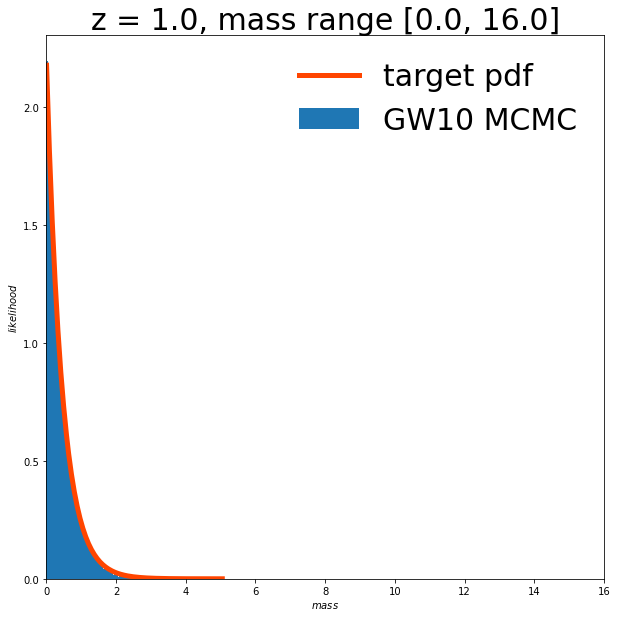

In [17]:
test_func, mass_chain = mass_sampling([0.0, 16.0], redshift = 1.0)
plot_pdf(mass_chain, "z = 1.0, mass range [0.0, 16.0]", func=test_func, xlims=[0.0, 16.0], ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


 Done with burn-in:  22.750627756118774
 Done with MCMC:  4.584865093231201


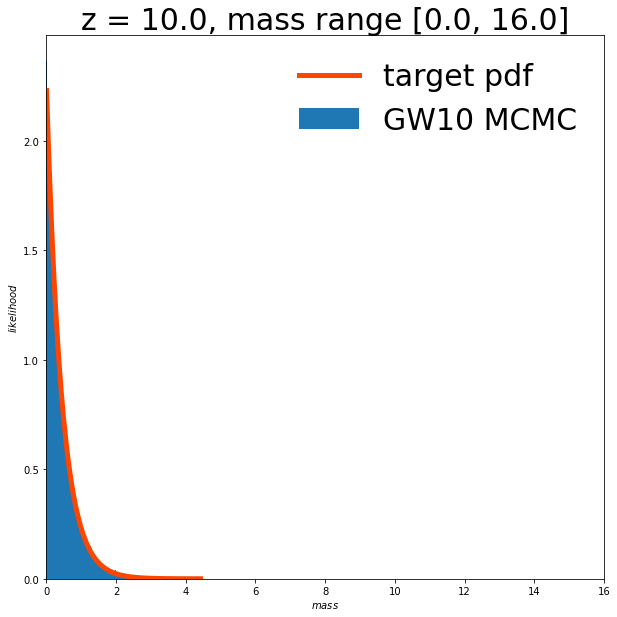

In [18]:
test_func, mass_chain = mass_sampling((0.0, 14.0), redshift = 10.0)
plot_pdf(mass_chain, "z = 10.0, mass range [0.0, 16.0]", func=test_func, xlims=[0.0, 16.0], ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

Deleted outdated persistence file, no further action needed.
 Done with burn-in:  23.250125646591187
 Done with MCMC:  4.721510410308838


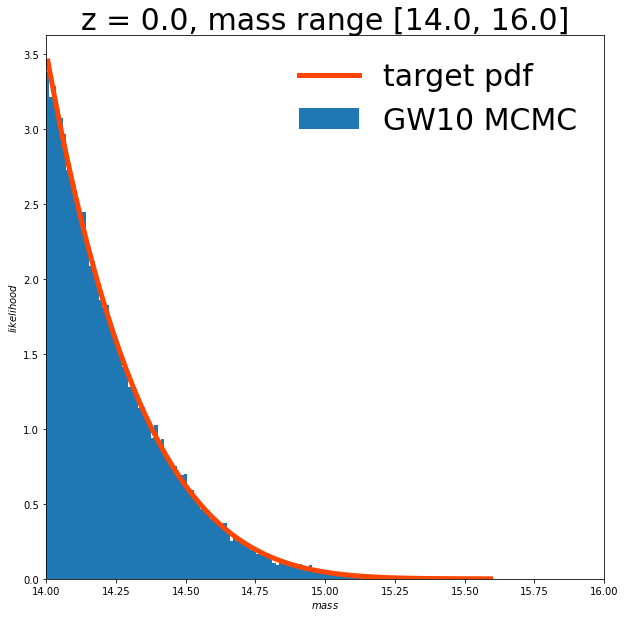

In [19]:
#test model, mdef, sample_num
test_func, mass_chain = mass_sampling((14, 16), redshift = 0.0, mdef = 'vir', model = 'seppi20', sample_num = 100000)
plot_pdf(mass_chain, "z = 0.0, mass range [14.0, 16.0]", func=test_func, xlims=[14.0, 16.0], ylog=False, bins='auto', label='GW10 MCMC', figsize = 10)

# **Multiple Redshift**

multiple redshift sample
, shape of redshift reference: 
1. https://arxiv.org/pdf/2101.08373.pdf
2. https://pole.uchicago.edu/public/data/sptsz-clusters/


code reference: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skewnorm.html#scipy.stats.skewnorm

In [20]:
def skew_sample(size = 10000):
    """
    the function to give back a sample of redshift based on skew gaussian distribution imitating SPT cluster data: https://pole.uchicago.edu/public/data/sptsz-clusters/
      
    Parameters:
    ----------- 
    size: integer, sample number

    mass_chain: a NumPy array of length = sample_num
    rs_sample: an 1d NumPy array of clusters' redshift sample with length = size
    """
    from scipy.stats import skewnorm
    a = 4
    sample = skewnorm.rvs(a, loc = 2, scale = 2, size = size) 
    rs_sample = sample/6.6666
    return rs_sample 
     

In [21]:
def single_redshift_num(rs_range, sample_num, rs_dist_model):
    """
    the function to give back redshifts and sample_num per redshift for multi-redshift sampling

    Parameters:
    ----------- 
    rs_dist_model: a string, represent the distribution of cluster redshift
    rs_range: a tuple of redshift range, (0.0, 1.5) by default
    sample_num: an integer of number of sample, 100000 by default
    
    chop: a NumPy array of redshifts
    num_per_redshift: a NumPy array of cluster num within the corresponding redshift interval of same index number in chop
    """
    if rs_dist_model == "skewnorm": #more option reserved for future improvement
        rs_sample = skew_sample(size = sample_num)

    #calculate chop_num, eg. rdshift = (0, 1.5) -> 90 chop. 1 chop take 22-25s to sample, be careful
    chop_num = (rs_range[1] - rs_range[0]) * 60
    chop = np.linspace(rs_range[0], rs_range[1], int(chop_num)) # an array of redshift upper & lower limit, redshift in this range will be approximate to lower limit
    num_per_redshift = [] 
    for i, redshift in enumerate(chop):
        min_rs = redshift
        condition1 = (min_rs <= rs_sample)
        if redshift != 1.5:
            max_rs = chop[i + 1]
        else:
            max_rs = float('inf')
        condition2 = (rs_sample < max_rs)
        condition = condition1 & condition2

        num = np.count_nonzero(condition) #num of cluster fulfill this range
        num_per_redshift.append(num) 

    num_per_redshift = np.array(num_per_redshift) 

    fin_chop_num = np.count_nonzero(num_per_redshift >= 20)
    print(f"you divide redshift range {rs_range} into {fin_chop_num} chops, it will take about {round(fin_chop_num*22.5/60, 3)} minutes to complete.")
    return chop, num_per_redshift 


In [22]:
def mul_redshift_mass_sampling(rs_dist = "skewnorm", rs_range = (0.0, 1.5), mass_range = (14.0, 16.0), mdef = '200c', model = 'bocquet16', sample_num = 100000, store = True):
    """
    the function to give back a sample of multi-redshift cluster mass distribution based on halo mass function
  
    Parameters:
    -----------
    rs_dist: a string, representing the distribution of cluster redshift, "skewnorm" by default
    rs_range: a tuple of redshift range, (0.0, 1.5) by default
    mass_range: a tuple of cluster masses, lower limit and upper limit for sampling, [min, max] in 10^min M⨀ unit
    mdef: The mass definition in which the halo mass M is given; see colossus doc for more info (https://bdiemer.bitbucket.io/colossus/lss_mass_function.html#lss.mass_function.massFunction)
    model: the halo mass function model used by colossus; see colossus doc for more info
    sample_num: an integer of the number of samples, 100000 by default
    store: a boolean, if True store mass array and redshift into a csv file and return a string of path to file if False returns None
    
    fin_cluster: a Pandas dataframe with 2 col of ["mass_arr", "redshift"], NumPy array of cluster mass corresponding to redshift stored in each row
    filepath: str of file path if store=True, else None
    tot_num: a integer of final sample number, there's a small difference between sample_num and tot_num caused by conditions
    """  
  
    t0 = time.time()
    import pandas as pd
    filepath = None
    chop, num_per_redshift = single_redshift_num(rs_range, sample_num, rs_dist)

    final_mass_list = []
    tot_num = 0
    flag = 0 #cannot use i = 0 to initiate masses and redshifts.
    for i, redshift in enumerate(chop):
        redshift = round(redshift, 4)
        sample_n = num_per_redshift[i]
        if sample_n < 20: #->too small
            continue
        sample_n = int(math.ceil(sample_n / 10.0)) * 10 #round up
        print(f"starting sampling with redshift: {redshift}, sample_num : {sample_n}")
        test_func, chain = mass_sampling(mass_range, redshift = redshift, mdef = mdef, model = model, sample_num = sample_n)
        tot_num += chain.shape[0]
        if (flag == 0):
            masses = pd.Series(reverse_extract_power(chain))
            rs_arr = np.full((chain.shape[0]), redshift)
            redshifts = pd.Series(rs_arr)
            flag = 1
        else:
            new_mass = pd.Series(reverse_extract_power(chain))
            masses = pd.concat([masses, new_mass])
            rs_arr = np.full((chain.shape[0]), redshift)
            new_redshift = pd.Series(rs_arr)
            redshifts = pd.concat([redshifts, new_redshift])
        #mass_sampling(mass_range, redshift = 0.0, mdef = '200c', model = 'bocquet16', sample_num = 100000):
        #final_mass_list.append(masses(test_func, redshift, chain))
    fin_clusters = pd.DataFrame(columns = ["mass_arr", "redshift"])
    fin_clusters["mass_arr"] = masses
    fin_clusters["redshift"] = redshifts

    if store:
        from pathlib import Path
        filepath = Path(os.getcwd() + "/mass_samples/" + "rs(" + str(rs_range[0]) + "~" + str(rs_range[1]) + ")num_" + str(tot_num) + ".csv")
        filepath.parent.mkdir(parents = True, exist_ok = True)
        fin_clusters.to_csv(filepath, index = False)
    t1 = time.time()
    print(f"finish running, using {t1 - t0}s, obtain {tot_num} cluster samples")
    return tot_num, filepath, fin_clusters
    


test & demo

In [39]:
tot_num, filepath, clusters = mul_redshift_mass_sampling(rs_dist = "skewnorm", rs_range = (0.0, 1.5), mass_range = (14.0, 16.0), mdef = '200c', model = 'bocquet16', sample_num = 300, store = True)


you divide redshift range (0.0, 1.5) into 1 chops, it will take about 0.375 minutes to complete.
starting sampling with redshift: 0.4888, sample_num : 20
Deleted outdated persistence file, no further action needed.
 Done with burn-in:  23.520428895950317
 Done with MCMC:  0.004579782485961914
finish running, using 23.73649501800537s, obtain 20 cluster samples


In [44]:
#the final number of sample equals to tot_num! (instead of sample_num)
print(clusters)
print(f"final sample number is {tot_num}")

        mass_arr  redshift
0   1.024220e+14    0.4888
1   1.242109e+14    0.4888
2   1.865493e+14    0.4888
3   1.013854e+14    0.4888
4   1.835305e+14    0.4888
5   1.046374e+14    0.4888
6   1.154933e+14    0.4888
7   1.201874e+14    0.4888
8   2.899768e+14    0.4888
9   1.400941e+14    0.4888
10  1.211568e+14    0.4888
11  1.463786e+14    0.4888
12  1.047662e+14    0.4888
13  1.644570e+14    0.4888
14  1.135834e+14    0.4888
15  2.433082e+14    0.4888
16  2.640830e+14    0.4888
17  1.480174e+14    0.4888
18  1.111495e+14    0.4888
19  1.399492e+14    0.4888
final sample number is 20


In [40]:
#1. use clusters (dataframe directly)
cluster_arr = clusters.to_numpy()
print(cluster_arr)

#[[mass1, redshift1], [mass2, redshift2], ...]

[[1.02421981e+14 4.88800000e-01]
 [1.24210873e+14 4.88800000e-01]
 [1.86549291e+14 4.88800000e-01]
 [1.01385382e+14 4.88800000e-01]
 [1.83530536e+14 4.88800000e-01]
 [1.04637434e+14 4.88800000e-01]
 [1.15493350e+14 4.88800000e-01]
 [1.20187352e+14 4.88800000e-01]
 [2.89976834e+14 4.88800000e-01]
 [1.40094068e+14 4.88800000e-01]
 [1.21156791e+14 4.88800000e-01]
 [1.46378637e+14 4.88800000e-01]
 [1.04766186e+14 4.88800000e-01]
 [1.64456960e+14 4.88800000e-01]
 [1.13583424e+14 4.88800000e-01]
 [2.43308165e+14 4.88800000e-01]
 [2.64083002e+14 4.88800000e-01]
 [1.48017446e+14 4.88800000e-01]
 [1.11149464e+14 4.88800000e-01]
 [1.39949151e+14 4.88800000e-01]]


In [41]:
#2. use csv file, path given by filepath
clusters_from_file = pd.read_csv(filepath)
clusters_from_file_arr = clusters_from_file.to_numpy()
print(cluster_arr)

[[1.02421981e+14 4.88800000e-01]
 [1.24210873e+14 4.88800000e-01]
 [1.86549291e+14 4.88800000e-01]
 [1.01385382e+14 4.88800000e-01]
 [1.83530536e+14 4.88800000e-01]
 [1.04637434e+14 4.88800000e-01]
 [1.15493350e+14 4.88800000e-01]
 [1.20187352e+14 4.88800000e-01]
 [2.89976834e+14 4.88800000e-01]
 [1.40094068e+14 4.88800000e-01]
 [1.21156791e+14 4.88800000e-01]
 [1.46378637e+14 4.88800000e-01]
 [1.04766186e+14 4.88800000e-01]
 [1.64456960e+14 4.88800000e-01]
 [1.13583424e+14 4.88800000e-01]
 [2.43308165e+14 4.88800000e-01]
 [2.64083002e+14 4.88800000e-01]
 [1.48017446e+14 4.88800000e-01]
 [1.11149464e+14 4.88800000e-01]
 [1.39949151e+14 4.88800000e-01]]


In [ ]:
mul_redshift_mass_sampling(rs_dist = "skewnorm", rs_range = (0.0, 1.5), mass_range = (14.0, 16.0), mdef = '200c', model = 'bocquet16', sample_num = 100000, store = True)